In [13]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Creating a DataFrame

path = 'dataset/loan_dataset.csv'
df_original = pd.read_csv(path)
df_original.head()

df_original = pd.DataFrame(df_original)

# Filtering the specified columns
filtered_df = df_original[[
    'Employment_Status', 'Annual_Income', 'Credit_Score',  'Outstanding_Debt', 'Loan_Amount_Requested', 
    'Loan_Type','Loan_Purpose', 'Loan_Approval_Status'
]]

# 'Total_Existing_Loan_Amount'

filtered_df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Purpose,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,Home,1
1,Employed,21162,468,18321,8288,Unsecured,Home,0
2,Self-Employed,27815,389,13851,10308,Secured,Vehicle,0
3,Self-Employed,137853,778,28608,33937,Secured,Personal,1
4,Employed,81753,752,8780,23360,Unsecured,Home,1
...,...,...,...,...,...,...,...,...
51995,Self-Employed,56085,381,11909,15723,Secured,Home,1
51996,Self-Employed,79062,726,24696,21209,Unsecured,Vehicle,1
51997,Unemployed,57471,396,12367,10540,Unsecured,Education,0
51998,Employed,49495,362,13240,16765,Secured,Vehicle,0


In [14]:
# Filter on home loan applications
filtered_df_home = filtered_df[filtered_df['Loan_Purpose'] == 'Home']


df = filtered_df_home.drop(columns=['Loan_Purpose'])
df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,1
1,Employed,21162,468,18321,8288,Unsecured,0
4,Employed,81753,752,8780,23360,Unsecured,1
8,Self-Employed,121626,803,13940,20239,Secured,0
10,Self-Employed,54670,772,22104,20000,Unsecured,1
...,...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured,1
51989,Unemployed,118085,714,9803,30183,Secured,0
51990,Self-Employed,134581,756,15172,24717,Unsecured,1
51992,Unemployed,34019,572,19031,8383,Unsecured,0


In [15]:
nan_count = df.isna().sum()
print(nan_count)



Employment_Status        0
Annual_Income            0
Credit_Score             0
Outstanding_Debt         0
Loan_Amount_Requested    0
Loan_Type                0
Loan_Approval_Status     0
dtype: int64


# fuzzification

documentation: https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html

/Users/brageramberg/opt/miniconda3/envs/INF264/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


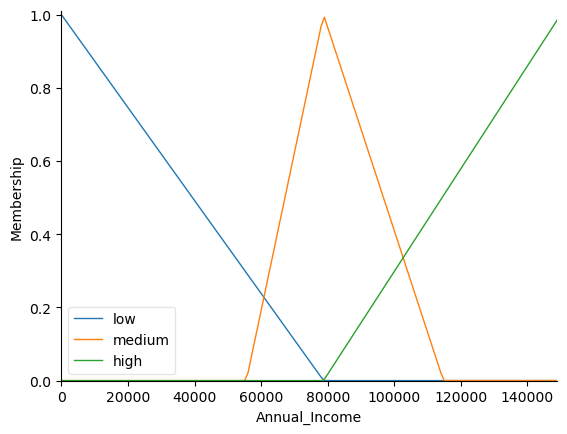

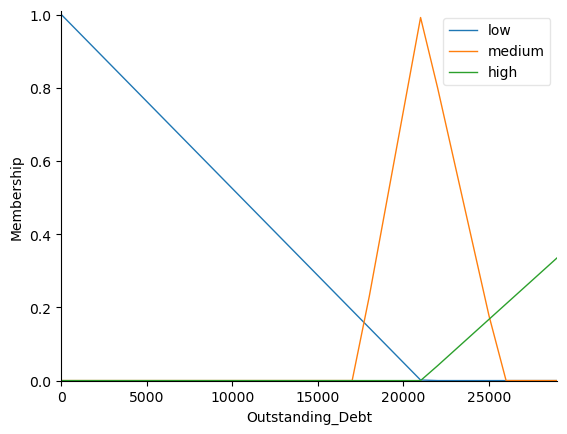

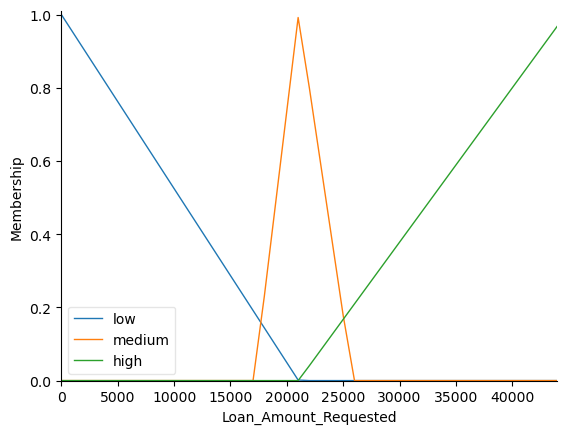

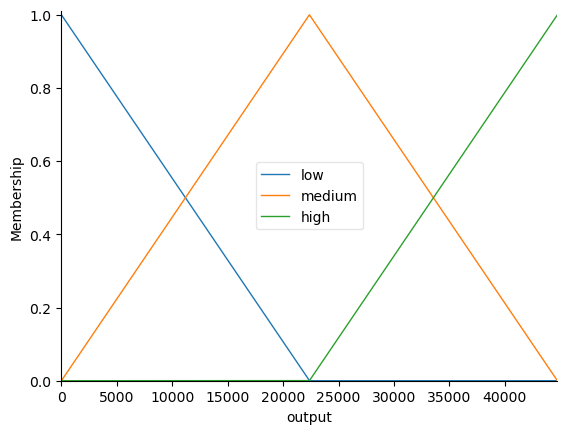

In [59]:
# Calculating the max, min, and average of 'Annual_income' column
max_income = df['Annual_Income'].max()
max_loan = df['Loan_Amount_Requested'].max()
max_outstanding_debt = df['Outstanding_Debt'].max()

def custom_fuzzification(antecedent, data, column_name):
    """
    Sets up 'low', 'medium', and 'high' fuzzy membership functions for a given column in the data.
    
    Parameters:
    - antecedent: The fuzzy antecedent to apply the memberships to (e.g., annual_income).
    - data: The DataFrame containing the data.
    - column_name: The column name to base the membership functions on.
    """
    # Calculate cutoffs dynamically
    low_cutoff = data[column_name].quantile(0.5)
    medium_cutoff_start = data[column_name].quantile(0.25)
    medium_cutoff_middle = data[column_name].quantile(0.5)
    medium_cutoff_end = data[column_name].quantile(0.75)
    max_income_end = data[column_name].max()
    
    # Define triangular membership functions
    antecedent['low'] = fuzz.trimf(antecedent.universe, [0, 0, low_cutoff])
    antecedent['medium'] = fuzz.trimf(antecedent.universe, [medium_cutoff_start, medium_cutoff_middle, medium_cutoff_end])
    antecedent['high'] = fuzz.trimf(antecedent.universe, [medium_cutoff_middle, max_income_end, max_income_end])

# Custom fuzzification function
annual_income = ctrl.Antecedent(np.arange(0, max_income, 1000), 'Annual_Income')
loan_amount_requested= ctrl.Antecedent(np.arange(0, max_loan, 1000), 'Loan_Amount_Requested')
outstanding_debt = ctrl.Antecedent(np.arange(0, max_outstanding_debt, 1000), 'Outstanding_Debt')



# maybe average later or not
output = ctrl.Consequent(np.arange(0, max_loan+1, 1), 'output')

output['low'] = fuzz.trimf(output.universe, [0, 0, max_loan/2])
output['medium'] = fuzz.trimf(output.universe, [0, max_loan/2, max_loan])
output['high'] = fuzz.trimf(output.universe, [max_loan/2, max_loan, max_loan])



# Apply the custom fuzzification function
custom_fuzzification(annual_income, df, "Annual_Income")
custom_fuzzification(loan_amount_requested, df, "Loan_Amount_Requested")
custom_fuzzification(outstanding_debt, df, "Loan_Amount_Requested")

annual_income.view()
outstanding_debt.view()
loan_amount_requested.view()
output.view()

# rules

In [ ]:
rule1 = ctrl.Rule(annual_income['low'] & outstanding_debt['low'], output['low'])


In [ ]:
loan_amount_requested['low']